# EDA NOTEBOOK

This notebook:
1. Loads caption data.
2. Loads images and extracts features via VGG16.
3. Fits a tokenizer.
4. Performs Exploratory Data Analysis (EDA) with visualizations.
5. Splits the dataset into train/test.
6. Defines a data generator that yields partial sequences in batches.

## 1. Imports & Directory Setup

In [3]:
import os
import pickle
import numpy as np
import pandas as pd
from collections import defaultdict, Counter

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from tqdm.auto import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model

# Set up directories & file paths here: #

BASE_DIR = "../data"  
IMAGES_DIR = os.path.join(BASE_DIR, "Images")
CAPTIONS_FILE = os.path.join(BASE_DIR, "captions.txt")
WORKING_DIR = "../outputs"  # Where we store features.pkl, etc.

# Create outputs directory if not exists
if not os.path.exists(WORKING_DIR):
    os.makedirs(WORKING_DIR)

# This file will store the extracted VGG16 features
FEATURES_FILE = os.path.join(WORKING_DIR, "features.pkl")


## 2. Load Captions & Images, Extract CNN Features

In [4]:
def load_captions(file_path):
    """
    Loads captions from a text file of lines in the format:
    image_id,caption
    Returns a dict: {"image_id": ["caption1", "caption2", ...], ...}
    """
    captions_dict = defaultdict(list)
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if ',' in line:
                img_id, caption = line.split(',', 1)
                img_id = img_id.strip()
                caption = caption.strip()
                captions_dict[img_id].append(caption)
    return captions_dict

def extract_vgg16_features(img_dir, features_file):
    """
    Extract VGG16 fc2-layer features for all images in img_dir.
    If features_file exists, loads from it instead.
    Returns a dict: {"image_id": feature_array}
    """
    if os.path.exists(features_file):
        print("Loading precomputed features from:", features_file)
        with open(features_file, 'rb') as f:
            features = pickle.load(f)
        return features
    
    print("Extracting features with VGG16 (fc2 layer)...")
    # Load VGG16
    base_model = VGG16(weights='imagenet')
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)
    
    features = {}
    for img_name in tqdm(os.listdir(img_dir), desc='Processing Images'):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        # image_id is filename without extension
        image_id = os.path.splitext(img_name)[0]
        img_path = os.path.join(img_dir, img_name)
        # Load & preprocess image
        img = load_img(img_path, target_size=(224, 224))
        img_arr = img_to_array(img)
        img_arr = np.expand_dims(img_arr, axis=0)
        img_arr = preprocess_input(img_arr)
        # Extract fc2 features
        feature = model.predict(img_arr, verbose=0)
        features[image_id] = feature  # shape should be (1, 4096)

    # Save to file
    with open(features_file, 'wb') as f:
        pickle.dump(features, f)
    print("Features saved to:", features_file)
    return features

# 2.1 Load captions
print("Loading captions from:", CAPTIONS_FILE)
captions_dict = load_captions(CAPTIONS_FILE)
print(f"Loaded {len(captions_dict)} unique image IDs in captions.")

# 2.2 Extract or load precomputed features
features = extract_vgg16_features(IMAGES_DIR, FEATURES_FILE)
print(f"Total images with features: {len(features)}")

Loading captions from: ../data/captions.txt
Loaded 8092 unique image IDs in captions.
Extracting features with VGG16 (fc2 layer)...


Processing Images:   0%|          | 0/8091 [00:00<?, ?it/s]

Features saved to: ./outputs/features.pkl
Total images with features: 8091


## 3. Combine Captions, Tokenize, & Basic EDA

Total number of captions: 40456
First few captions: ['caption', 'A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .']
Vocabulary size (total unique words): 8495


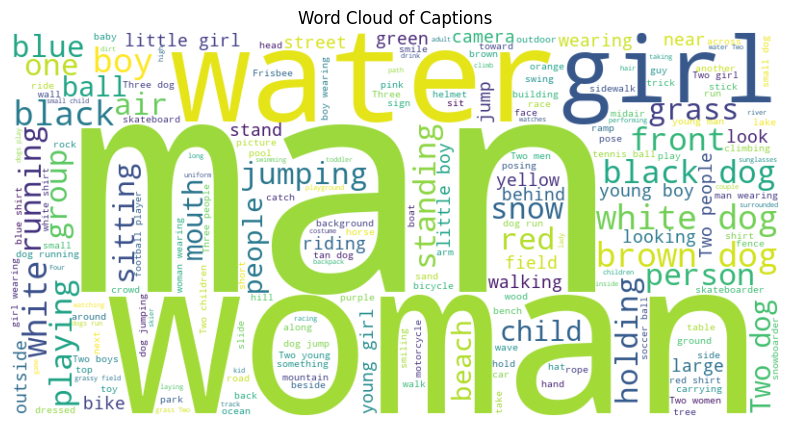

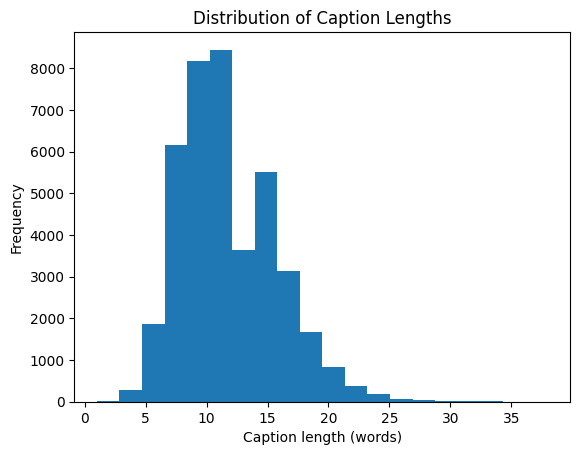


=== Basic Stats ===
Total Captions: 40456
Total Unique Images (with captions): 8092
Average Captions per Image: 5.0
Average Caption Length: 11.78
Max Caption Length: 38
Min Caption Length: 1
Vocabulary Size: 8495


In [5]:
# Combine all captions into one list
all_captions = []
caption_lengths = []

for img_id, caps in captions_dict.items():
    for c in caps:
        all_captions.append(c)
        caption_lengths.append(len(c.split()))

print("Total number of captions:", len(all_captions))
print("First few captions:", all_captions[:5])

# Initialize and fit tokenizer on all captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1  # Typically +1 for the 0 or pad token
print("Vocabulary size (total unique words):", vocab_size)

# Word Cloud
joined_captions = " ".join(all_captions)
wc = WordCloud(width=800, height=400, background_color='white').generate(joined_captions)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Captions")
plt.show()

# Caption length distribution
plt.hist(caption_lengths, bins=20)
plt.title("Distribution of Caption Lengths")
plt.xlabel("Caption length (words)")
plt.ylabel("Frequency")
plt.show()

# Print some stats
print("\n=== Basic Stats ===")
print("Total Captions:", len(all_captions))
print("Total Unique Images (with captions):", len(captions_dict))
print("Average Captions per Image:", round(len(all_captions) / len(captions_dict), 2))
print("Average Caption Length:", round(np.mean(caption_lengths), 2))
print("Max Caption Length:", np.max(caption_lengths))
print("Min Caption Length:", np.min(caption_lengths))
print("Vocabulary Size:", vocab_size)

## 4. Train/Test Split

In [6]:
# We only want images that actually have features extracted.
# So let's intersect the keys from captions with the keys from features.
valid_keys = [k for k in captions_dict if k in features]
print("Usable images (in both captions and features):", len(valid_keys))

# 90-10 split (you can adjust as needed)
train_split = 0.9
train_size = int(len(valid_keys) * train_split)
train_keys = valid_keys[:train_size]
test_keys = valid_keys[train_size:]

print("Train set image count:", len(train_keys))
print("Test set image count: ", len(test_keys))

Usable images (in both captions and features): 0
Train set image count: 0
Test set image count:  0


## 5. Data Generator (Corrected)

In [7]:
def data_generator(image_keys, captions_dict, features, tokenizer, max_length, vocab_size, batch_size=32):
    """
    Yields batches of (image, text), out_word.
    Each batch contains exactly `batch_size` partial sequences.
    """
    X1, X2, y = [], [], []  # lists for image features, input seq, output word
    n = 0  # counts how many partial sequences in current batch
    
    while True:
        for key in image_keys:
            # get all captions for this image
            caps = captions_dict[key]
            feature_vec = features[key][0]  # shape: (4096,) if fc2
            
            for caption in caps:
                # Convert the caption to a list of word indices
                seq = tokenizer.texts_to_sequences([caption])[0]

                # Generate partial sequences from 1..i words
                for i in range(1, len(seq)):
                    in_seq = seq[:i]
                    out_seq = seq[i]

                    # pad in_seq to max_length
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]

                    # one-hot encode output word
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store
                    X1.append(feature_vec)  # image features
                    X2.append(in_seq)       # input text sequence
                    y.append(out_seq)       # output word
                    n += 1

                    # if batch is full, yield it
                    if n == batch_size:
                        yield ({'image': np.array(X1), 'text': np.array(X2)}, np.array(y))
                        X1, X2, y = [], [], []
                        n = 0

max_length = max(len(c.split()) for c in all_captions)
print("Max caption length used for generator:", max_length)

batch_size = 32
print("Ready to build generators with batch_size=", batch_size)


Max caption length used for generator: 38
Ready to build generators with batch_size= 32
